In [16]:
import os
import yaml
import numpy as np
import pandas as pd
from omegaconf import OmegaConf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# configs

In [17]:
with open("configs/base.yaml", "r") as stream:
    base_config = yaml.safe_load(stream)
    
with open("configs/kdd99.yaml", "r") as stream:
    data_config = yaml.safe_load(stream)
    train_config = base_config.copy()
    test_config = base_config.copy()
    
    train_config.update(data_config['train'])
    test_config.update(data_config['test'])

train_config = OmegaConf.create(train_config)
test_config = OmegaConf.create(test_config)
train_config, test_config

({'seq_length': 30, 'num_signals': 6, 'normalise': False, 'noise_dim': 8, 'hidden_dim': 128, 'kappa': 1, 'degree': 1, 'learning_rate': 0.0002, 'batch_size': 32, 'epochs': 10, 'scale': 0.1, 'freq_low': 1.0, 'freq_high': 5.0, 'amplitude_low': 0.1, 'amplitude_high': 0.9, 'resample_rate_in_min': 15, 'lambda': 0.5, 'seq_step': 10, 'feature_dim': 35},
 {'seq_length': 30, 'num_signals': 6, 'normalise': False, 'noise_dim': 8, 'hidden_dim': 128, 'kappa': 1, 'degree': 1, 'learning_rate': 0.0002, 'batch_size': 32, 'epochs': 10, 'scale': 0.1, 'freq_low': 1.0, 'freq_high': 5.0, 'amplitude_low': 0.1, 'amplitude_high': 0.9, 'resample_rate_in_min': 15, 'lambda': 0.5, 'seq_step': 10, 'feature_dim': 35})

# Preprocess data

In [18]:
class CustomDataset(Dataset): 
    def __init__(self, path, config):
        self.path = path
        self.config = config
        self.seq_length = self.config.seq_length
        
        # kdd: npy file
        self.data = np.load(self.path)
        
        # drop rows with constant data --?
        #x[x[:, -1] != 0]
        self.data = (self.data - self.data.min(axis=0)) / (self.data.max(axis=0) - self.data.min(axis=0) + 1e-12)
        assert 0 <= np.min(self.data) and np.max(self.data) <= 1
        print(path.split('/')[-1], " : ", self.data.shape)
        
    def __len__(self): 
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length, :]
        return x
    
train_loader = DataLoader(CustomDataset('./data/kdd99/train.npy', train_config), batch_size=train_config.batch_size, shuffle=True)

train.npy  :  (562387, 35)


# Generator, Discriminator and Inverter

In [19]:
class discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_dim = self.config.hidden_dim
        self.seq_length = self.config.seq_length
        self.feature_dim = self.config.feature_dim
        
        self.lstm = nn.LSTM(self.feature_dim, self.hidden_dim, batch_first=True)
        self.prob_dec = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim // 2, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        o, _ = self.lstm(x)
        o = o[:, -1, :]
        p = self.prob_dec(o)
        return p
    
class generator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.seq_length = self.config.seq_length
        
        self.noise_dim = self.config.noise_dim
        self.hidden_dim = self.config.hidden_dim
        self.feature_dim = self.config.feature_dim
        
        self.noise_enc = nn.Sequential(
            nn.Linear(self.noise_dim, self.seq_length * self.hidden_dim),
        )
        self.lstm = nn.LSTM(self.hidden_dim, self.feature_dim, batch_first=True)
        self.data_dec = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim // 2, self.feature_dim),
        )
        
    def forward(self, z, return_hiddens=False):
        o = self.noise_enc(z)
        o = o.reshape(z.shape[0], self.seq_length, -1)
        o, hc = self.lstm(o)
        if return_hiddens:
            return o, hc
        else:
            return o
    
class Inverter(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.seq_length = self.config.seq_length
        
        self.noise_dim = self.config.noise_dim
        self.hidden_dim = self.config.hidden_dim
        self.feature_dim = self.config.feature_dim
        
        self.hidden_enc = nn.Sequential(
            nn.Linear(self.feature_dim, self.hidden_dim),
        )
        self.lstm = nn.LSTM(self.feature_dim, self.hidden_dim, batch_first=True)
        self.noise_dec = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim // 2, self.noise_dim),
        )
        
    def forward(self, x, hc=None):
        if hc:
            hc = tuple(self.hidden_enc(hc_) for hc_ in hc)
            o, _ = self.lstm(x, hc)
        else:
            o, _ = self.lstm(x)
        o = o[:, -1, :]
        p = self.noise_dec(o)
        return p
    
netD = discriminator(train_config).float()
netG = generator(train_config).float()
netI = Inverter(train_config).float()

optD = torch.optim.Adam(netD.parameters(), lr=train_config.learning_rate, betas=(0.9, 0.999))
optG = torch.optim.Adam(netG.parameters(), lr=train_config.learning_rate, betas=(0.9, 0.999))
optI = torch.optim.Adam(netI.parameters(), lr=train_config.learning_rate, betas=(0.9, 0.999))

# Train

In [21]:
losses = {'G': [], 'D': [], 'I': []}
for e in range(train_config.epochs):
    for x in tqdm(train_loader):
        x = x.float()
        z = torch.randn(x.shape[0], netG.noise_dim)

        optD.zero_grad()
        #fake_loss = nn.BCELoss()(netD(netG(torch.randn(x.shape[0], netG.noise_dim))), torch.zeros(x.shape[0], 1))
        D_fake_out = netD(netG(z))
        fake_loss = torch.mean(D_fake_out)
        #real_loss = nn.BCELoss()(netD(x), torch.ones(x.shape[0], 1))
        D_real_out = netD(x)
        real_loss = torch.mean(D_real_out)
        D_loss = fake_loss - real_loss
        D_loss.backward()
        optD.step()
        
        # Clip weights of discriminator
        for p in netD.parameters():
            p.data.clamp_(-0.01, 0.01)

        optG.zero_grad()
        #G_loss = nn.BCELoss()(netD(netG(torch.randn(x.shape[0], netG.noise_dim))), torch.ones(x.shape[0], 1))
        G_loss = -torch.mean(netD(netG(z)))
        optG.step()
        
        optI.zero_grad()
        x_, hc = netG(z, return_hiddens=True)
        x_, hc = x_.detach(), tuple(hc_.detach() for hc_ in hc)
        z_ = netI(x, hc)
        I_loss = nn.L1Loss()(z_, z)
        optI.step()

        losses['G'].append(G_loss.item())
        losses['D'].append(D_loss.item())
        losses['I'].append(I_loss.item())

    break
        

  0%|          | 0/17574 [00:00<?, ?it/s]

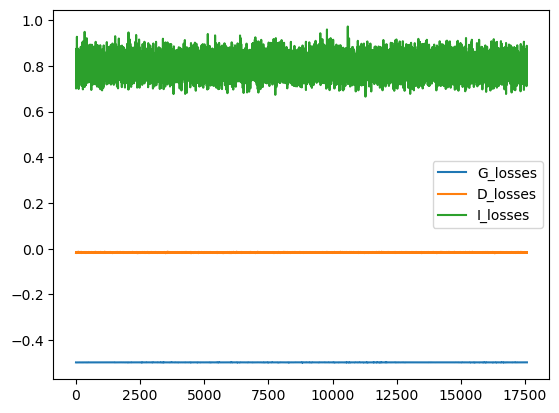

In [22]:
plt.plot(losses['G'], label='G_losses')
plt.plot(losses['D'], label='D_losses')
plt.plot(losses['I'], label='I_losses')
plt.legend()
plt.show()
plt.close()

# Evaluation

In [24]:
test_loader = DataLoader(CustomDataset('data/kdd99/test.npy', test_config), batch_size=test_config.batch_size, shuffle=False)
netD.eval(), netG.eval(), netI.eval()

L_scores = []
with torch.no_grad():
    for x in tqdm(test_loader):
        x = x.float()
        z = x.reshape(x.shape[0], -1)

        # compute score from D
        D_score = netD(x)
                
        # compute score from G
        G_score = nn.L1Loss()(netG(netI(x)), x)

        L_score = (test_config['lambda']) * D_score + (1 - test_config['lambda']) * G_score
        L_scores += L_score.tolist()
    

test.npy  :  (494021, 35)


  0%|          | 0/15438 [00:00<?, ?it/s]

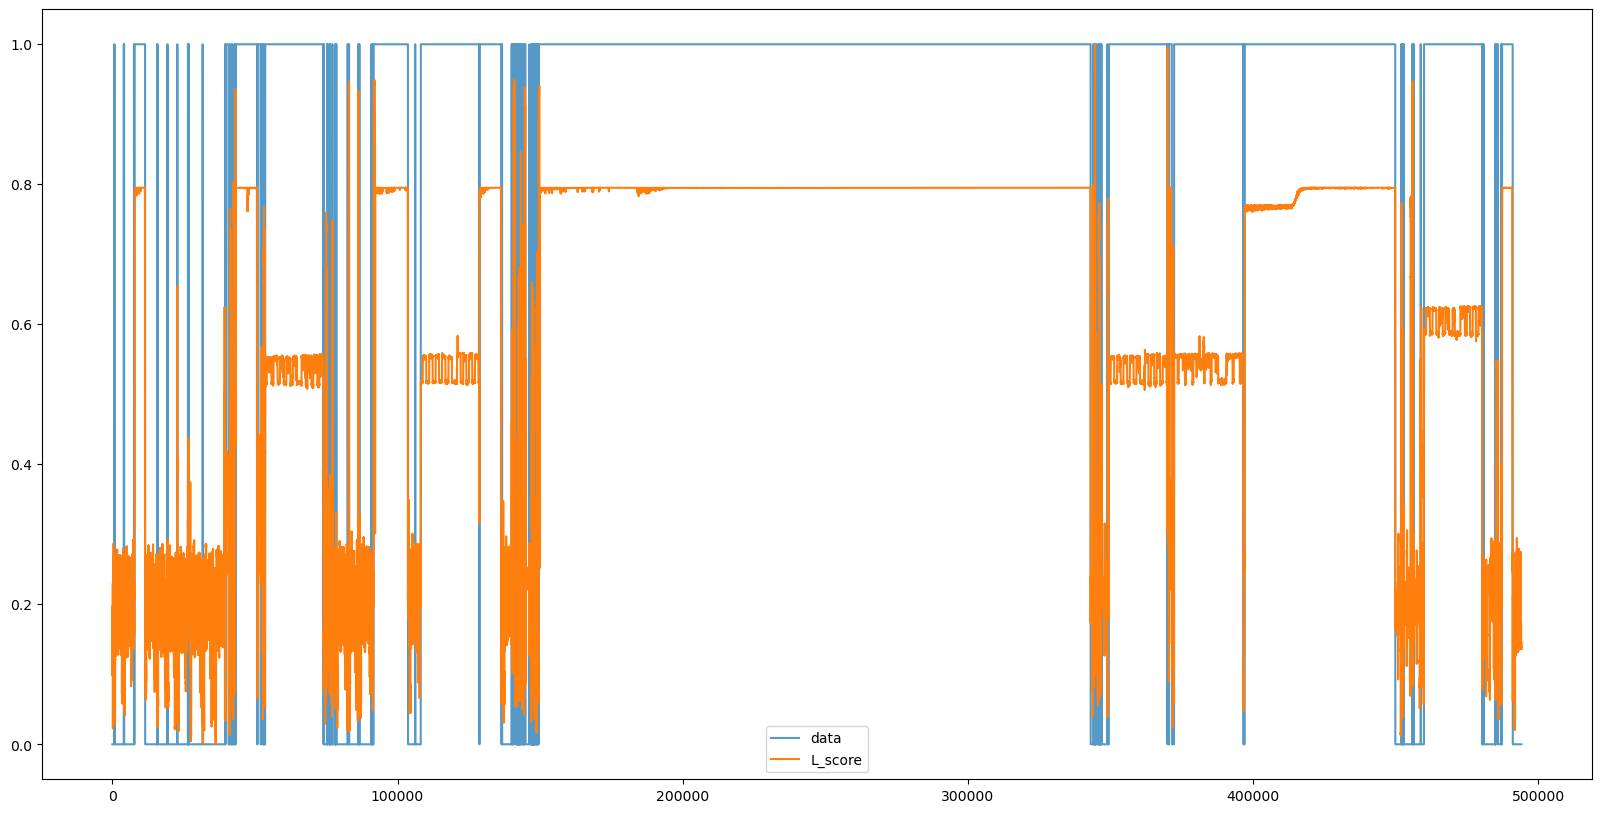

In [25]:
plt.figure(figsize=(20, 10))
L_scores = np.array(L_scores)
scaled_score = (L_scores - L_scores.min(axis=0)) / (L_scores.max(axis=0) - L_scores.min(axis=0) + 1e-12)
plt.plot(test_loader.dataset.data[:, -1], label='data', alpha=0.75)
plt.plot(scaled_score, label='L_score')
plt.legend()
plt.show()
plt.close()

In [ ]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss